 Iter          Cost_f           Error
    0    3.812791e-02    5.307689e-01
   70    1.002805e+00    7.498241e-13
 Iter          Cost_f           Error
    0    5.348936e-01    1.085179e-02
   55    1.258189e+00    8.361642e-13
 Iter          Cost_f           Error
    0    6.009706e-01    4.015413e-03
   60    1.358870e+00    4.361231e-13
 Iter          Cost_f           Error
    0    6.292354e-01    1.403363e-03
   55    1.399936e+00    9.942003e-13
 Iter          Cost_f           Error
    0    3.156486e-01    1.323526e-02
   59    1.039427e+00    8.153884e-13
 Iter          Cost_f           Error
    0    5.708142e-01    1.090250e-02


   59    1.326244e+00    6.872169e-13
 Iter          Cost_f           Error
    0    6.748464e-01    5.570520e-03
   62    1.476854e+00    5.207588e-13
 Iter          Cost_f           Error
    0    7.319220e-01    2.778581e-03
   57    1.557912e+00    9.762672e-13
 Iter          Cost_f           Error
    0    7.632938e-01    1.388930e-03
   54    1.602364e+00    9.754431e-13
 Iter          Cost_f           Error
    0    7.806588e-01    6.533613e-04
   50    1.627034e+00    9.183142e-13
 Iter          Cost_f           Error
    0    7.903353e-01    3.155744e-04
   48    1.640863e+00    7.670059e-13
 Iter          Cost_f           Error
    0    3.130240e-01    1.527652e-02
   59    1.075976e+00    9.796871e-13
 Iter          Cost_f           Error
    0    5.743259e-01    9.653067e-03
   58    1.354919e+00    8.948622e-13
 Iter          Cost_f           Error
    0    7.034546e-01    6.218080e-03
   55    1.535474e+00    8.388617e-13
 Iter          Cost_f           Error
    0    7.8

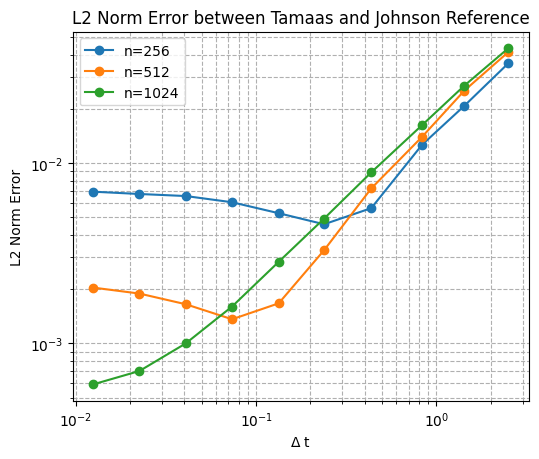

In [2]:
import tamaas as tm
import matplotlib.pyplot as plt
import tamaas.utils
import numpy as np
import time
from scipy.optimize import curve_fit

# Parallel computation
tm.initialize(8)

# Load constant
W = 1e0  # Total load
L = 1.0  # Domain size
Radius = 0.01

n_list = [256, 512, 1024]  # Discretization list

# Loading conditions and material properties
model_E = 3
model_nu = 0.5
nu = 0.5

beta_values_dict = {}
execution_times_dict = {}
error_list_dict = {}

for n in n_list:
    # Model setup
    physical_size = [L, L]
    discritization = [n, n]
    model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)
    model.E = model_E
    model.nu = model_nu

    shear_modulus = [model.mu]
    characteristic_time = [1]

    # Hertz surface
    surface = tm.utils.hertz_surface(physical_size, discritization, Radius)

    # Hertz and Johnson reference solutions
    G_inf = model.mu
    G = shear_modulus

    tau = characteristic_time
    eta = [g * t for g, t in zip(G, tau)]

    g_1 = 2 * (G[0] + G_inf)
    g_2 = -g_1 * (2 * G_inf / (2 * G_inf - g_1))

    e_1 = 2 * (G[0] + G_inf) * (1 + model.nu)
    K = 2 * G_inf * (1 + model.nu)
    tau_c = [t * e_1 / K for t in tau]

    G_maxwell_t0 = sum(G)
    G_effective_t0 = G_inf + G_maxwell_t0
    E_effective_t0 = 2 * G_effective_t0 * (1 + model.nu) / (1 - model.nu**2)

    p0_t0 = (6 * W * (E_effective_t0)**2 / (np.pi**3 * Radius**2))**(1/3)
    a_t0 = (3 * W * Radius / (4 * E_effective_t0))**(1/3)
    Ac_hertz_t0 = np.pi * a_t0**2

    E_effective_inf = 2 * G_inf * (1 + model.nu) / (1 - model.nu**2)
    p0_t_inf = (6 * W * (E_effective_inf)**2 / (np.pi**3 * Radius**2))**(1/3)
    a_t_inf = (3 * W * Radius / (4 * E_effective_inf))**(1/3)
    Ac_hertz_t_inf = np.pi * a_t_inf**2

    time_steps_list = np.geomspace(4, 800, 10, dtype=int)
    error_list = []

    t0 = 0
    t1 = 10
    t0 /= np.min(characteristic_time)
    t1 /= np.min(characteristic_time)

    #solve for target pressure
    p_target = W / (L**2) #avarge pressure

    for time_steps in time_steps_list:
        dt = (t1 - t0) / time_steps
        Ac_tamaas = []
        Ac_Johnson_ref = []
        solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)
        solver.reset()

        for i in range(time_steps):
            solver.solve(p_target)
            contact_area_result = np.mean(model.traction > 0) * L**2
            normalized_result = contact_area_result / L**2
            Ac_tamaas.append(normalized_result)

        for t in np.arange(t0, t1, dt):
            Ac_Johnson_ref.append((3 / 8 * Radius * W * (1 / g_1 + 1 / g_2 * (1 - np.exp(-t / tau_c[0]))))**(2/3) * np.pi)

        Ac_tamaas = Ac_tamaas[:-1]
        Ac_Johnson_ref = Ac_Johnson_ref[1:]

        L2_norm = np.sqrt(np.sum((np.array(Ac_tamaas) - np.array(Ac_Johnson_ref))**2))
        error = L2_norm / np.linalg.norm(Ac_Johnson_ref)
        error_list.append(error)

    dt_list = [(t1 - t0) / time_steps for time_steps in time_steps_list]

    error_list_dict[n] = error_list
    execution_times_dict[n] = dt_list

# Plot log-log graph of L2 norms
plt.figure()
for n in n_list:
    plt.loglog(execution_times_dict[n], error_list_dict[n], marker='o', label=f'n={n}')
plt.xlabel('$\Delta$ t')
plt.ylabel('L2 Norm Error')
plt.title('L2 Norm Error between Tamaas and Johnson Reference')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()
